In [ ]:
# Define the CNN model
class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(self._get_flattened_size((3, 64, 64)), 512)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.relu2(self.conv2(x)))
            x = self.pool3(self.relu3(self.conv3(x)))
            return x.numel()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x


# Number of classes in the dataset
model = SignLanguageCNN(num_classes)

# Print the model structure
print(model)


SignLanguageCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout4): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=26, bias=True)
)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 2.2943, Val Loss: 1.1954, Train Acc: 0.3065, Val Acc: 0.5860
Epoch 2/20, Train Loss: 0.9798, Val Loss: 0.4604, Train Acc: 0.6775, Val Acc: 0.8680
Epoch 3/20, Train Loss: 0.5122, Val Loss: 0.3216, Train Acc: 0.8227, Val Acc: 0.9100
Epoch 4/20, Train Loss: 0.3695, Val Loss: 0.1739, Train Acc: 0.8818, Val Acc: 0.9460
Epoch 5/20, Train Loss: 0.2332, Val Loss: 0.1319, Train Acc: 0.9269, Val Acc: 0.9660
Epoch 6/20, Train Loss: 0.1714, Val Loss: 0.1628, Train Acc: 0.9399, Val Acc: 0.9500
Epoch 7/20, Train Loss: 0.1479, Val Loss: 0.0895, Train Acc: 0.9529, Val Acc: 0.9760
Epoch 8/20, Train Loss: 0.1305, Val Loss: 0.0997, Train Acc: 0.9624, Val Acc: 0.9680
Epoch 9/20, Train Loss: 0.1823, Val Loss: 0.0581, Train Acc: 0.9444, Val Acc: 0.9860
Epoch 10/20, Train Loss: 0.1202, Val Loss: 0.0395, Train Acc: 0.9639, Val Acc: 0.9840
Epoch 11/20, Train Loss: 0.1016, Val Loss: 0.0373, Train Acc: 0.9659, Val Acc: 0.9840
Epoch 12/20, Train Loss: 0.0694, Val Loss: 0.0388, Train Acc: 0

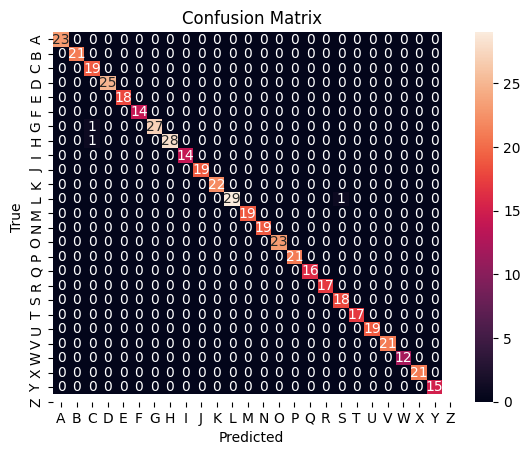

In [ ]:
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Enable CUDA Synchronization for Debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Define a custom dataset
class SignLanguageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))

        for label_idx, label in enumerate(self.classes):
            label_dir = os.path.join(data_dir, label)
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                self.data.append(img_path)
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        return img, label

# Data augmentation and preprocessing
IMG_SIZE = (64, 64)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   transforms.GaussianBlur(kernel_size=3),
])

# Define the CNN model
class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(self._get_flattened_size((3, 64, 64)), 512)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.relu2(self.conv2(x)))
            x = self.pool3(self.relu3(self.conv3(x)))
            return x.numel()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

# Constants
NUM_CLASSES = 26  # A-Y
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 32

# Dataset Path
DATASET_PATH = '/content/drive/MyDrive/Data'

# Load dataset
full_dataset = SignLanguageDataset(DATASET_PATH, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, loss, optimizer
device = torch.device('cpu')  # Force CPU for debugging
model = SignLanguageCNN(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Ensure labels are long integers
        labels = labels.long()

        # Check label values
        assert (labels >= 0).all() and (labels < NUM_CLASSES).all(), f"Invalid label value: {labels}"

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Ensure labels are long integers
            labels = labels.long()

            # Check label values
            assert (labels >= 0).all() and (labels < NUM_CLASSES).all(), f"Invalid label value: {labels}"

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_accuracy = correct_val / total_val
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Val Acc: {val_accuracy:.4f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Fix classification report
actual_classes = sorted(unique_labels(all_labels))
actual_class_names = [full_dataset.classes[i] for i in actual_classes]

# report = classification_report(all_labels, all_preds, labels=actual_classes, target_names=actual_class_names)
# print(report)

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/sign_language_modell2.pth')


In [ ]:
print(f"Classes found in dataset: {full_dataset.classes}")


Classes found in dataset: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


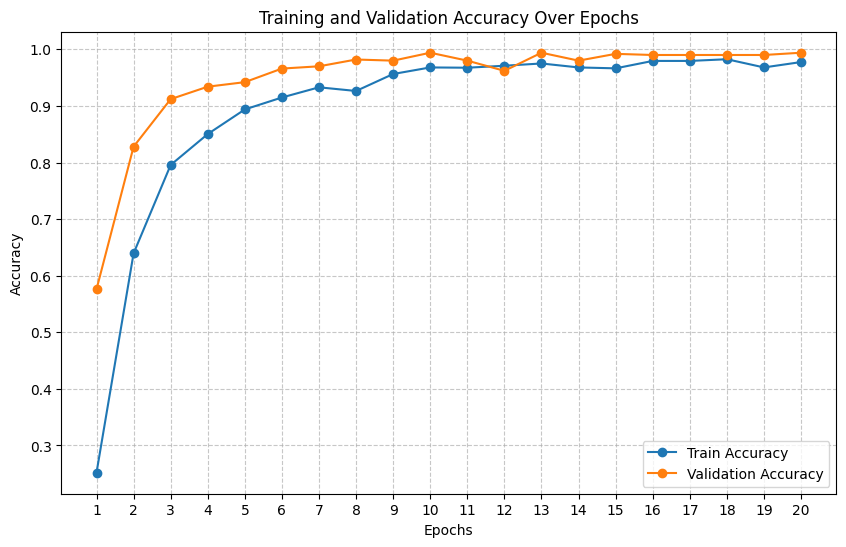

In [ ]:
# Data for training and validation accuracy
import matplotlib.pyplot as plt
train_accuracies = [
    0.2519, 0.6395, 0.7957, 0.8503, 0.8938, 0.9149, 0.9329, 0.9264, 0.9564, 0.9680,
    0.9675, 0.9710, 0.9750, 0.9680, 0.9664, 0.9795, 0.9795, 0.9825, 0.9680, 0.9775
]

val_accuracies = [
    0.5760, 0.8280, 0.9120, 0.9340, 0.9420, 0.9660, 0.9700, 0.9820, 0.9800, 0.9940,
    0.9800, 0.9620, 0.9940, 0.9800, 0.9920, 0.9900, 0.9900, 0.9900, 0.9900, 0.9940
]

# Plot training and validation accuracy
epochs = range(1, 21)  # 20 epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')

# Add labels, title, legend
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


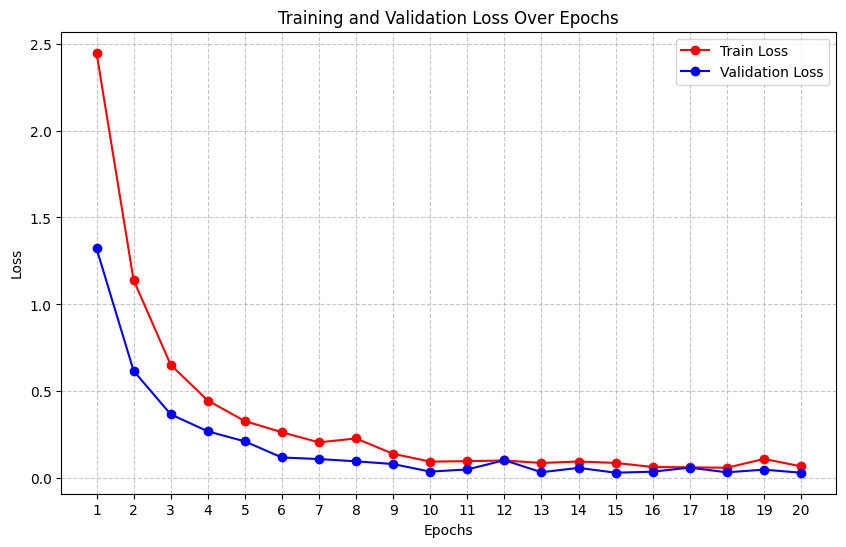

In [ ]:
# Data for training and validation loss
train_losses = [
    2.4475, 1.1399, 0.6530, 0.4473, 0.3292, 0.2648, 0.2067, 0.2292, 0.1407, 0.0961,
    0.0985, 0.1025, 0.0882, 0.0966, 0.0885, 0.0651, 0.0631, 0.0606, 0.1114, 0.0688
]

val_losses = [
    1.3222, 0.6182, 0.3680, 0.2703, 0.2123, 0.1198, 0.1107, 0.0977, 0.0820, 0.0384,
    0.0511, 0.1040, 0.0349, 0.0600, 0.0322, 0.0381, 0.0614, 0.0344, 0.0498, 0.0321
]

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o', color='red')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='blue')

# Add labels, title, legend
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import os
import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define a custom dataset
class SignLanguageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))

        for label_idx, label in enumerate(self.classes):
            label_dir = os.path.join(data_dir, label)
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                self.data.append(img_path)
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        return img, label

# Data augmentation and preprocessing
IMG_SIZE = (64, 64)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset Path
DATASET_PATH = '/content/drive/MyDrive/Data'

# Load dataset
full_dataset = SignLanguageDataset(DATASET_PATH, transform=transform)

# Total number of images in the dataset before augmentation
total_images_before = len(full_dataset)
print(f"Total images in the dataset before augmentation: {total_images_before}")

# Training parameters
BATCH_SIZE = 32
EPOCHS = 20

# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Estimated total augmented images during training
batches_per_epoch = len(train_loader)
total_augmented_images = batches_per_epoch * BATCH_SIZE * EPOCHS
print(f"Estimated total augmented images during training: {total_augmented_images}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images in the dataset before augmentation: 2497
Estimated total augmented images during training: 40320


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-3-a350f7275c09>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/sign_language_modell2.pth'))


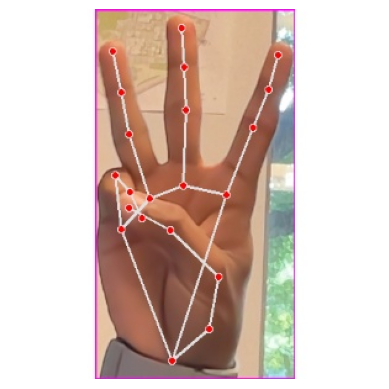

Predicted Class: W


In [ ]:
import torch
import torchvision.transforms as transforms
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Dataset path where the images are stored (replace with actual dataset path)
DATASET_PATH = '/content/drive/MyDrive/Data'

# Define the CNN model
class SignLanguageCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.dropout1 = torch.nn.Dropout(0.2)

        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.dropout2 = torch.nn.Dropout(0.2)

        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(2, 2)
        self.dropout3 = torch.nn.Dropout(0.3)

        self.fc1 = torch.nn.Linear(self._get_flattened_size((3, 64, 64)), 512)
        self.relu4 = torch.nn.ReLU()
        self.dropout4 = torch.nn.Dropout(0.4)
        self.fc2 = torch.nn.Linear(512, num_classes)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.relu2(self.conv2(x)))
            x = self.pool3(self.relu3(self.conv3(x)))
            return x.numel()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

# Load the pre-trained model
model = SignLanguageCNN(num_classes=26)  # Assuming 26 classes (A-Z)
model.load_state_dict(torch.load('/content/drive/MyDrive/sign_language_modell2.pth'))
model.eval()  # Set the model to evaluation mode

# Load and preprocess the image using OpenCV
def preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Resize the image
    image = cv2.resize(image, (64, 64))  # Resize to the model's input size

    # Normalize the image (scale pixel values to [0, 1])
    image = image / 255.0

    # Convert to PyTorch tensor and normalize
    image = torch.tensor(image).permute(2, 0, 1).float()  # Change shape to [C, H, W]
    image = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image)

    return image.unsqueeze(0)  # Add batch dimension

def predict_image(image_path):
    # Preprocess the image
    input_tensor = preprocess_image(image_path)

    # Move tensor to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    input_tensor = input_tensor.to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, dim=1)

    # Get the class label
    class_labels = sorted(os.listdir(DATASET_PATH))  # Replace with your class names list
    predicted_label = class_labels[predicted_class.item()]

    print(f"Predicted Class: {predicted_label}")

# Example Usage
image_path = '/content/drive/MyDrive/Data/W/Image_1686847180.157401.jpg'
predict_image(image_path)
